# Non Linear Optimization

## Overview

The majority of this notebook's goal is to expore non linear optimization algorithms. The algorithms and methods will start from unconstrained optimization to develop the base foundational knowledge needed to understand constained optimization. The algorithms from this book and logic are derived from the followin resources mainly

    - Numerical Optimization by Nocedal and Wright

## Background

While the main objective of this notebook is to be as numerical and application based as possible there are a couple of theorems that are necessary to explain and present in order to develop a complete understanding of the algorithms. Optimization refers to the minimization or maximization of a function subject to constraints on its variables. In most cases in non linear optimization the goal of finding the global solution among all the feasible points is quite difficult but finding local solution where the objective function is smaller than all other feasible nearby points isn't as difficult so the focus will be on this. 

##### Convexity

A set $S \in \mathbb{R}^n$ is a convex set if the straight line segment connecting any two points in S lies entirely inside S. A **convex function** satisfies the following for any two points $x$ and $y$ and $\alpha \in [0,1]$:

$$ 
\begin{equation} \tag{2} f(\alpha x + (1-\alpha)y) \leq \alpha f(x) + (1-\alpha)f(y), \quad \text{for all } \alpha \in [0,1] \end{equation}
$$


##### Gradient

If $f$ is a smooth function that is twice differentiable we can determine if the $x^{*}$ is a local minimizer by looking at the gradient.  **Gradient** : $\nabla f(x^*)$: is a vector that points in the direction of the greatest rate of increase of a scalar function. gradient tells you how the function fff changes as you move in different directions in the space defined by the variables. The magnitude of the gradient gives the rate of change of the function, and the direction of the gradient points in the direction of the steepest ascent.

$$ 
\nabla f(x_1, x_2, \dots, x_n) = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots, \frac{\partial f}{\partial x_n} \right) 
$$

##### Hessian

The hessian tells you the curvature of the function and how the gradient change in the direction of one or multiple variables. A positive definite hessian means that the function has a local minimum at that point. 


$$ 
H(f) = \begin{pmatrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \dots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\ \frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \dots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \dots & \frac{\partial^2 f}{\partial x_n^2} \end{pmatrix} 
$$


##### First Order Necessary Condition
If $x^∗$ is a local minimizer and $f$ is continuously differentiable in an open neighborhood of $x^∗$, then $\nabla f(x^*) = 0$

##### Second Order Necessary Conditions
If $x^*$ is a local minimizer of $f$ and $\nabla^2f$ exists and is continuous in an open neighborhood of $x^*$, then  $\nabla f(x^*) = 0$ and $\nabla^2f(x^*)$ is positive semidefinite.

##### Second Order Sufficient Conditions
Suppose that $\nabla^2f$ is continuous in an open neighborhood of $x^*$ and that $\nabla f(x^*) = 0$ and $\nabla^2f(x^*)$ is positive definite. Then $x^*$ is a strict local minimizer of $f$.

##### Wolfe Conditions

There are two conditions which make up the Wolfe Conditions

1) A sufficient decrease can be defined as the Armijo Condition$$\tag{3.2} f(x_k+\alpha p_k) \leq f(x_k) +c_1\alpha  \nabla f_k^T p_k$$ where 
- $c_1$ is a constant that controls the amount of reduction of $f(x_k)$ that we are looking for
- $\alpha$ how much we move in the direction of $p_k$
	- As you take a bigger step you expect a bigger decrease in the function
- $\nabla f_k^T p_k$ how much the function will change in the direction of k. This term will be negative since $p_k$

2) To ensure that our step size is big enough $\alpha_k$ must satisfy $$\nabla f (x_k +\alpha_kp_k)^T p_k \geq c_2 \nabla f_k^T p_k $$


To ensure that $\alpha_k$ to lie in the broad neighborhood of a local minimizer or stationary point we introduce the **strong Wolfe Conditions** where we require $\alpha_k$ to satisfy  $$ | \nabla f (x_k +\alpha_kp_k)^T p_k | \geq c_2 |\nabla f_k^T p_k|$$

The first condition can be known as the sufficient decrease condition and the second the curvature condition. 


## Unconstrained Non-Linear Optimization

In order to test our results of the algorithms they will be tested against the following benchmarks that are considered to be the gold standard optimization problem that will show when different algorithms break!

1) Rose

## Line Search Method

The First Type of unconstained optimization methods that will be looked into is group of optimization algorithms known as line search methods. The first step is to choose a step lenghth that results in a sufficient decrease therefore we introduce the following

## Algo 1: Backtracking Line Search

By choosing steps correctly we can ensure that we don't need the curvature condition from the wolfe condition. This means that we can use sufficient decrease to terminate a line search process.

The initial part is the setup for the coding: We choose to use a combination of jax, matplotlib, and polars!

In [37]:
####################################
# Loading in the Necessary Libraries
####################################


import jax.numpy as jnp
import polars as pl
import matplotlib.pyplot as plt
import jax
from mpl_toolkits.mplot3d import Axes3D # For 3D plot
import numpy as np

The example problem that we choose to use is the Rosenbrock function: which is the classical Optimization Problem that can be used for testing the quality of certain optimization problems. We choose 

In [38]:
#####
# Develop the Model Probelem: Rosenbrock Function
#####

# This is the loop version-not vectorized - for illustration purposes
def rosenbrock_loop(x):
    sum = 0
    for i in range(len(x)-1):
        result = 100 * (x[i+1]-x[i]**2)**2 +(1-x[i])**2
        sum+=result
    return sum

# Creating the Jax version which is optimized
def rosenbrock_jnp(x):
    x_array = jnp.array(x)
    return jnp.sum(100 *(x_array[1:] - x_array[:-1]**2)**2 + (1-x_array[:-1])**2)

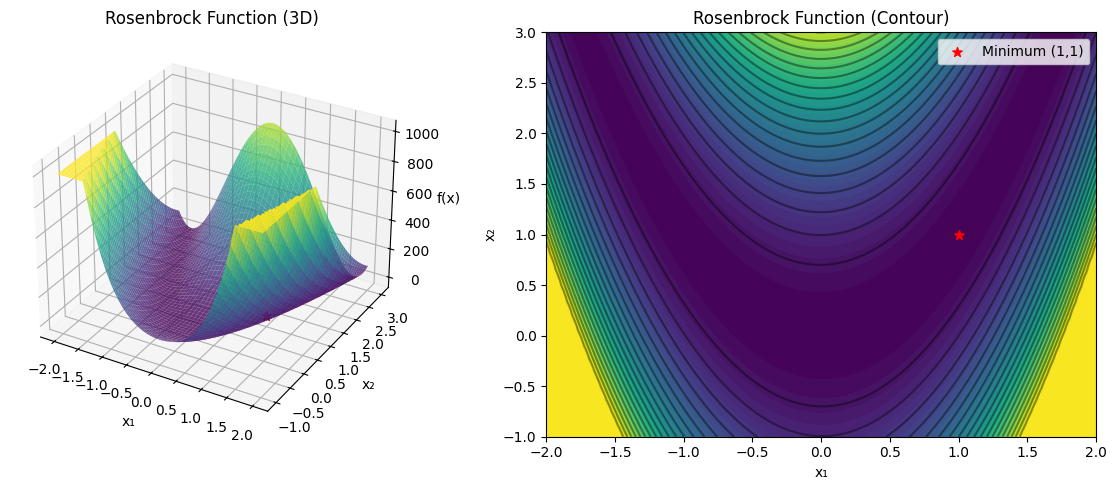

In [39]:

def plot_rosenbrock_simple_jax(rosenbrock_func):
    """
    Plot a simplified 2D and 3D visualization of the Rosenbrock function using JAX.
    """
    # 1. Create a grid of points using JAX
    x_vals = jnp.linspace(-2, 2, 100)
    y_vals = jnp.linspace(-1, 3, 100)
    X, Y = jnp.meshgrid(x_vals, y_vals)

    # 2. Evaluate the Rosenbrock function on the grid using JAX
    # We need to apply the function to each pair (X[i,j], Y[i,j])
    grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    Z_flat = jax.vmap(rosenbrock_func)(grid_points)
    Z = Z_flat.reshape(X.shape)

    # 3. Clip Z values for better visualization (optional, but often helpful)
    Z_clipped = jnp.clip(Z, 0, 1000)

    # 4. Convert JAX arrays to NumPy arrays for Matplotlib
    # This is necessary because matplotlib works with NumPy arrays
    X_np = np.array(X)
    Y_np = np.array(Y)
    Z_np = np.array(Z_clipped)

    # 5. Create the plots
    fig = plt.figure(figsize=(12, 5))

    # 3D Surface plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X_np, Y_np, Z_np, cmap='viridis', alpha=0.8)
    ax1.set_title('Rosenbrock Function (3D)')
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.set_zlabel('f(x)')

    # Mark the minimum point
    min_point_np = np.array([1.0, 1.0])
    min_z_np = rosenbrock_func(jnp.array(min_point_np)) # Calculate with JAX
    ax1.scatter(min_point_np[0], min_point_np[1], np.array(min_z_np), color='red', s=50, marker='*', label='Minimum (1,1)')


    # 2D Contour plot
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.contourf(X_np, Y_np, Z_np, 50, cmap='viridis')
    ax2.contour(X_np, Y_np, Z_np, 20, colors='black', alpha=0.4)
    ax2.set_title('Rosenbrock Function (Contour)')
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')

    # Mark the minimum point
    ax2.scatter(min_point_np[0], min_point_np[1], color='red', s=50, marker='*', label='Minimum (1,1)')

    fig.tight_layout()
    plt.legend()
    plt.show()

# Assuming your rosenbrock_jnp function is defined:
# from your_notebook_file import rosenbrock_jnp # or define it here
plot_rosenbrock_simple_jax(rosenbrock_jnp)

In [40]:
###########
# Since We are going to be running alot of Optimization we are going to create a Logging to
# track the performance of the different optimizers for unconstrained optimizations
######

class OptimizerLogger:
    def __init__(self, check_hessian=True):
        self._logs = []
        self.check_hessian = check_hessian
    
    def log(self, iter_num, x, fx, grad, alpha, p_k=None, hessian=None):
        """Log optimization iteration data."""
        grad_norm = jnp.linalg.norm(grad)
        
        log_entry = {
            "iteration": iter_num,
            "x": x.tolist(),
            "fval": float(fx.item() if hasattr(fx, 'item') else fx),
            "grad_norm": float(grad_norm.item() if hasattr(grad_norm, 'item') else grad_norm),
            "alpha": float(alpha)
        }
        
        # Calculate cosine of angle between search direction and negative gradient
        if p_k is not None:
            p_k_norm = jnp.linalg.norm(p_k)
            if p_k_norm > 0 and grad_norm > 0:
                # cos(θ) between search direction and negative gradient
                # Perfect alignment = 1.0 (steepest descent direction)
                cos_theta = jnp.dot(-grad, p_k) / (grad_norm * p_k_norm)
                log_entry["cos_theta"] = float(cos_theta)
        
        # Check Hessian conditioning if provided
        if self.check_hessian and hessian is not None:
            # Ensure symmetry
            hessian = 0.5 * (hessian + jnp.transpose(hessian))
            
            try:
                # Compute eigenvalues
                eigvals = jnp.linalg.eigvalsh(hessian)
                min_eig = jnp.min(eigvals)
                max_eig = jnp.max(eigvals)
                
                # Check conditioning
                if min_eig > 1e-10:
                    cond_num = max_eig / min_eig
                    log_entry["condition_number"] = float(cond_num)
                    log_entry["ill_conditioned"] = bool(cond_num > 1e6)
                else:
                    log_entry["ill_conditioned"] = True
                    
                log_entry["min_eigenvalue"] = float(min_eig)
                log_entry["max_eigenvalue"] = float(max_eig)
                
                # Check if non-convex region (negative eigenvalue)
                log_entry["is_convex"] = bool(min_eig > 0)
                
            except:
                log_entry["hessian_error"] = True
        
        self._logs.append(log_entry)
    
    def to_polars(self):
        """Convert logs to a Polars DataFrame."""
        return pl.DataFrame(self._logs)
    
    def print_summary(self):
        """Print optimization summary with conditioning info."""
        if not self._logs:
            print("No optimization data recorded")
            return
            
        first = self._logs[0]
        last = self._logs[-1]
        
        print("=== Optimization Summary ===")
        print(f"Iterations: {len(self._logs)}")
        print(f"Initial value: {first['fval']:.6e}")
        print(f"Final value: {last['fval']:.6e}")
        print(f"Improvement: {first['fval'] - last['fval']:.6e}")
        print(f"Final gradient norm: {last['grad_norm']:.6e}")

            # Add this section to display the final point coordinates
        print(f"\nInitial point: {first['x']}")
        print(f"Final point: {last['x']}")
        
        # Direction quality analysis
        if any("cos_theta" in log for log in self._logs):
            cos_values = [log.get("cos_theta", 0) for log in self._logs if "cos_theta" in log]
            avg_cos = sum(cos_values) / len(cos_values)
            min_cos = min(cos_values)
            print(f"\nDirection Quality (cos θ):")
            print(f"  Average: {avg_cos:.4f}")
            print(f"  Minimum: {min_cos:.4f}")
            
            if min_cos < 0:
                print(" WARNING: Non-descent direction detected (cos θ < 0)")
            elif min_cos < 0.1:
                print(" WARNING: Near-orthogonal directions detected (cos θ ≈ 0)")
        
        # Report conditioning issues
        ill_conditioned = any(log.get("ill_conditioned", False) for log in self._logs)
        if ill_conditioned:
            print("\n WARNING: Ill-conditioned Hessian detected!")
            
            # Find worst condition number
            cond_numbers = [log.get("condition_number", 0) for log in self._logs 
                           if "condition_number" in log]
            if cond_numbers:
                worst = max(cond_numbers)
                print(f"Worst condition number: {worst:.2e}")
                
        # Report non-convexity
        non_convex = any(not log.get("is_convex", True) for log in self._logs)
        if non_convex:
            print("WARNING: Non-convex region detected (negative Hessian eigenvalue)")
            
        print("===========================")
    def plot_grad_norms(self):
        """Plot convergence of gradient norms on a log scale."""
        if not self._logs:
            print("No logs to plot.")
            return

        grad_norms = [log["grad_norm"] for log in self._logs]
        iterations = [log["iteration"] for log in self._logs]

        plt.figure(figsize=(8, 5))
        plt.semilogy(iterations, grad_norms, marker='o', linestyle='-', color='navy')
        plt.xlabel("Iteration")
        plt.ylabel("Gradient Norm (log scale)")
        plt.title("Convergence of Gradient Norms")
        plt.tight_layout()
        plt.show()

In [41]:
##############
# Backtracking Line Search
# Algo 3.1 in Nocedal and Wright
# Reducing the Step Size Until We achieve sufficient Decrease through backtracking
#############

def backtracking_line_search(fx ,alpha,rho ,p_k , c, x):
    assert 0 <= rho <= 1, f" Rho must be between 0 and 1, got {rho}"
    assert alpha > 0, f" Initial Step Size must be greater than 0, got {alpha}"
    assert 0 <= c <= 1, f" c must be between 0 and 1, got {c}"

    grad_f = jax.grad(fx)
    grad_f_x = grad_f(x)
 

    while fx(x + alpha * p_k) > fx(x) + c* alpha * jnp.vdot(grad_f_x, p_k):
        alpha = alpha *rho
    return alpha


#############
# Steepest Descent using Line Search
############
def steepest_descent(fx, initial_x, max_iter=100, tol=1e-6, alpha=1.0, rho=0.5, c=1e-4, logger=None):
    """
    Steepest Descent method with backtracking line search.
    
    Args:
        fx: Objective function.
        initial_x: Starting point (JAX array or array-like).
        max_iter: Max number of iterations.
        tol: Tolerance on gradient norm for stopping.
        alpha: Initial step size.
        rho: Shrinkage factor for backtracking.
        c: Armijo condition parameter.
        logger: Optional OptimizerLogger instance.
    """
    x = jnp.array(initial_x)
    grad_f = jax.grad(fx)

    for i in range(max_iter):
        grad = grad_f(x)
        grad_norm = jnp.linalg.norm(grad)

        if grad_norm < tol:
            if logger:
                logger.log(i, x, fx(x), grad, alpha, p_k=None)
            print(f"Converged at iteration {i} with grad norm {grad_norm:.2e}")
            break

        p_k = -grad
        alpha_k = backtracking_line_search(fx, alpha, rho, p_k, c, x)
        x_new = x + alpha_k * p_k

        if logger:
            logger.log(i, x, fx(x), grad, alpha_k, p_k=p_k)

        x = x_new

    return x




Given the sensitivity of the Rosenbrock function: the initial parameters play a huge difference in terms of the number of iterations that it takes for the function to converge to the minimum. There is a special case scenraio where since the Rosenbrock converges very quickly at the point -1,1. The gradient only exists in the $x_1$ direction here so this makes the gradient partially equal to zero. This creates a unique trajector that follows the ridge of the function. This means that they follow the valley more directly compared to the point that we chose -1.2, 1 where it is following a more zigzag path. This the valley is extremly narrow which makes path differences significant. 

=== Optimization Summary ===
Iterations: 1000
Initial value: 2.420000e+01
Final value: 7.470874e-04
Improvement: 2.419926e+01
Final gradient norm: 3.912072e-02

Initial point: [-1.2000000476837158, 1.0]
Final point: [0.9726703763008118, 0.9460453391075134]

Direction Quality (cos θ):
  Average: 1.0000
  Minimum: 1.0000


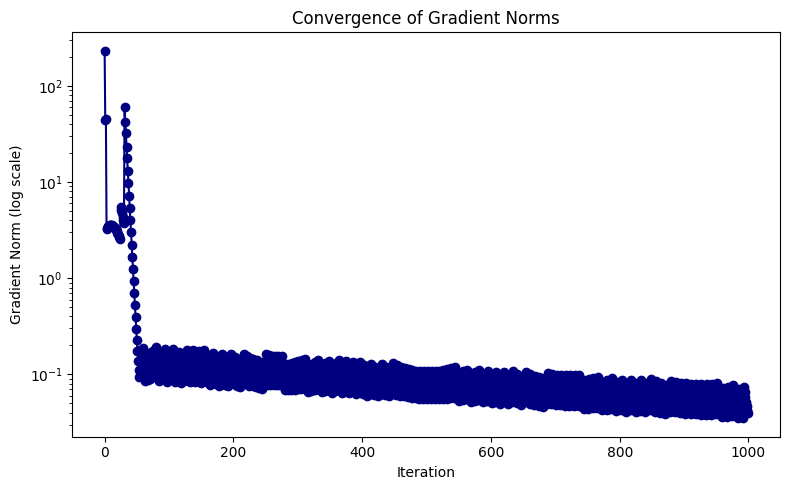

In [45]:
# Initialize logger
logger = OptimizerLogger(check_hessian=False)

# Run optimization
x0 = jnp.array([-1.2, 1.0])
opt_x = steepest_descent(rosenbrock_jnp, x0, max_iter=10000, tol=1e-6, logger=logger)

# Print summary and plot convergence
logger.print_summary()
logger.plot_grad_norms()